In [5]:
import os
import random
import requests
import warnings
from datetime import datetime

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [6]:

# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [7]:
new_df.head(2)

,time,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,relative_humidity_2m_mean,weather_label,Complaint_Count_diff1
0,2022-06-10,41.0,0.1,4,6,16.6,10,2022,47,1,NaN
1,2022-06-11,41.0,0.2,5,6,25.3,12,2022,42,1,2.0


In [8]:
df = new_df.drop(columns=['relative_humidity_2m_mean', 'Complaint_Count_diff1'])

In [9]:
df.set_index('time', inplace=True)

In [10]:
df.head(2)

,temp_max_C,precip_mm,day_of_week,month,wind_speed_max_m_s,Complaint_Count,year,weather_label
time,,,,,,,,
2022-06-10,41.0,0.1,4,6,16.6,10,2022,1
2022-06-11,41.0,0.2,5,6,25.3,12,2022,1


In [11]:
df.shape

(1183, 8)

In [12]:
# Separate features (X) and target (y)
X = df.drop(columns=['Complaint_Count'])
y = df['Complaint_Count']

In [13]:
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (946, 7)
X_test shape: (237, 7)
y_train shape: (946,)
y_test shape: (237,)


In [14]:
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Date range - Train: {df.index[0]} to {df.index[train_size-1]}")
print(f"Date range - Test: {df.index[train_size]} to {df.index[-1]}")


Training set size: 946
Test set size: 237
Date range - Train: 2022-06-10 to 2025-01-30
Date range - Test: 2025-01-31 to 2025-10-19


### MODEL TRAINING

In [15]:
# Define SARIMAX parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 24)  # (P, D, Q, s)

# Train SARIMAX model
model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)


# Fit the model
results = model.fit(disp=False, maxiter=200)


c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
print("\nModel trained successfully!")
print("\n" + results.summary().tables[0].as_text())


Model trained successfully!

                                     SARIMAX Results                                      
Dep. Variable:                    Complaint_Count   No. Observations:                  946
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3296.430
Date:                            Thu, 30 Oct 2025   AIC                           6616.860
Time:                                    01:15:21   BIC                           6674.422
Sample:                                         0   HQIC                          6638.855
                                            - 946                                         
Covariance Type:                              opg                                         


In [17]:
# MODEL EVALUATION ON TEST SET

# Make predictions on test set
y_pred_test = results.forecast(steps=len(y_test), exog=X_test)


c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100 # <--- This line calculates MAPE

print("\n" + "="*60)
print("Model Performance on Test Set")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%") # <--- This line prints MAPE


Model Performance on Test Set
Mean Absolute Error (MAE): 19.3831
Root Mean Squared Error (RMSE): 24.6310
R² Score: -0.7876
Mean Absolute Percentage Error (MAPE): nan%


In [19]:
# Combine actual and predicted values
results_forcast = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_test.values
}, index=y_test.index)

In [20]:
results_forcast

,Actual,Predicted
time,,
2025-01-31,44,19.442134
2025-02-01,22,18.878971
2025-02-02,26,18.126920
2025-02-03,13,19.843181
2025-02-04,40,19.037932
...,...,...
2025-10-15,18,22.097898
2025-10-16,18,24.385645
2025-10-17,17,20.871099


In [21]:
mae = mean_absolute_error(results_forcast['Actual'], results_forcast['Predicted'])
rmse = np.sqrt(mean_squared_error(results_forcast['Actual'], results_forcast['Predicted']))
mape = np.mean(np.abs((results_forcast['Actual'] - results_forcast['Predicted']) / results_forcast['Actual'])) * 100
r2 = r2_score(results_forcast['Actual'], results_forcast['Predicted'])

print("\n📈 Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2   : {r2:.2f}")



📈 Model Evaluation Metrics:
MAE  : 19.3831
RMSE : 24.6310
MAPE : 43.93%
R2   : -0.79


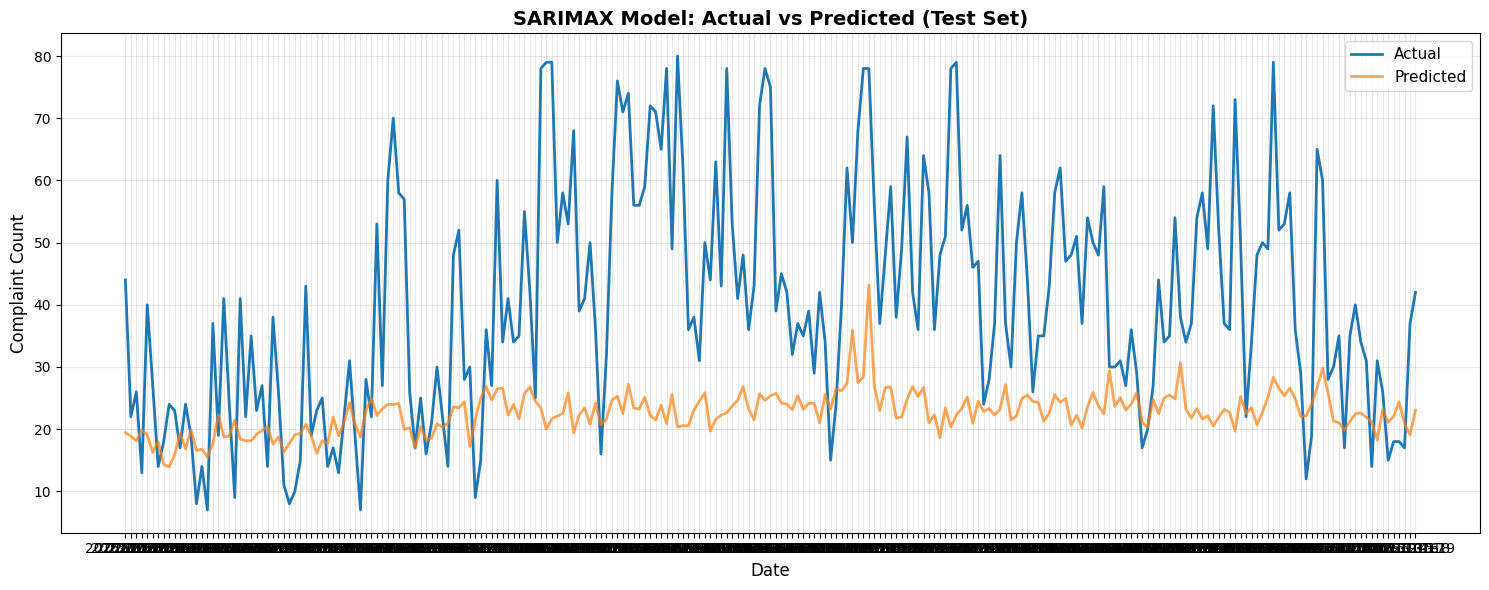

In [22]:
# VISUALIZATION OF TEST SET PREDICTIONS
plt.figure(figsize=(15, 6))
plt.plot(df.index[train_size:], y_test.values, label='Actual', linewidth=2)
plt.plot(df.index[train_size:], y_pred_test.values, 
         label='Predicted', linewidth=2, alpha=0.7)
plt.title('SARIMAX Model: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Complaint Count', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
# FORECASTING NEXT 30 DAYS
# For future forecasting, you need to provide exogenous variables
# Here are three approaches:
# APPROACH 1: Using the last known values (simple method)
# Repeat the last row of exogenous variables


X_future_simple = pd.DataFrame(
    np.tile(X.iloc[-1].values, (30, 1)),
    columns=X.columns
)

In [24]:
# APPROACH 2: Using mean values from the dataset
X_future_mean = pd.DataFrame(
    np.tile(X.mean().values, (30, 1)),
    columns=X.columns
)


In [25]:
# APPROACH 3: Use recent average (last 30 days)
X_future_recent = pd.DataFrame(
    np.tile(X.iloc[-30:].mean().values, (30, 1)),
    columns=X.columns
)


In [26]:
# Choose approach (using recent average as default)
X_future = X_future_recent

In [49]:
# Ensure last_date is a datetime object
last_date = pd.to_datetime(df.index[-1])

# Generate forecast dates
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

In [50]:
last_date

Timestamp('2025-10-19 00:00:00')

In [51]:
forecast_dates

DatetimeIndex(['2025-10-20', '2025-10-21', '2025-10-22', '2025-10-23',
               '2025-10-24', '2025-10-25', '2025-10-26', '2025-10-27',
               '2025-10-28', '2025-10-29', '2025-10-30', '2025-10-31',
               '2025-11-01', '2025-11-02', '2025-11-03', '2025-11-04',
               '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08',
               '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12',
               '2025-11-13', '2025-11-14', '2025-11-15', '2025-11-16',
               '2025-11-17', '2025-11-18'],
              dtype='datetime64[ns]', freq='D')

In [52]:
# Make 30-day forecast
forecast = results.forecast(steps=30, exog=X_future)
forecast_series = pd.Series(forecast.values, index=forecast_dates)

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [59]:
forecast_series

# Combine actual and predicted values
forcast = pd.DataFrame({
    'Pred': forecast_series.values
})

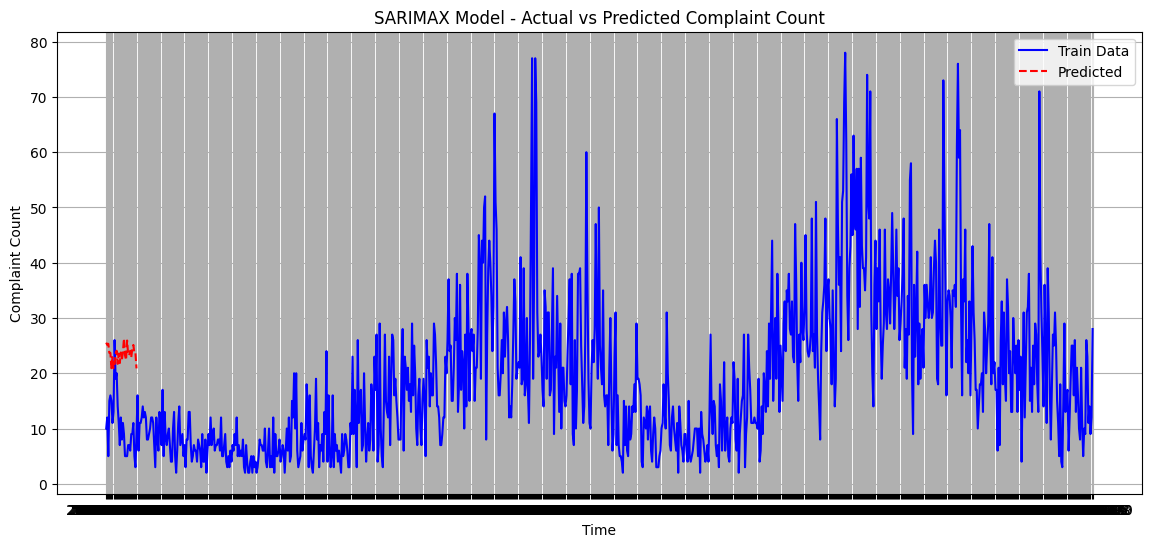

In [63]:
# Visualization: Actual vs Predicted

plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Train Data', color='blue')
plt.plot(forcast.index, forcast['Pred'], label='Predicted', color='red', linestyle='--')
plt.title('SARIMAX Model - Actual vs Predicted Complaint Count')
plt.xlabel('Time')
plt.ylabel('Complaint Count')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Calculate confidence intervals (95%)
forecast_obj = results.get_forecast(steps=30, exog=X_future)
forecast_ci = forecast_obj.conf_int()

c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
print(f"\nForecast period: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
print(f"\nForecast Summary:")
print(f"  Mean: {forecast.mean():.2f}")
print(f"  Min: {forecast.min():.2f}")
print(f"  Max: {forecast.max():.2f}")
print(f"  Std: {forecast.std():.2f}")


Forecast period: 2025-10-20 to 2025-11-18

Forecast Summary:
  Mean: 23.45
  Min: 20.88
  Max: 26.29
  Std: 1.46


In [34]:
%matplotlib inline


In [35]:
y.index = pd.to_datetime(y.index)


c:\Users\TPWODL\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


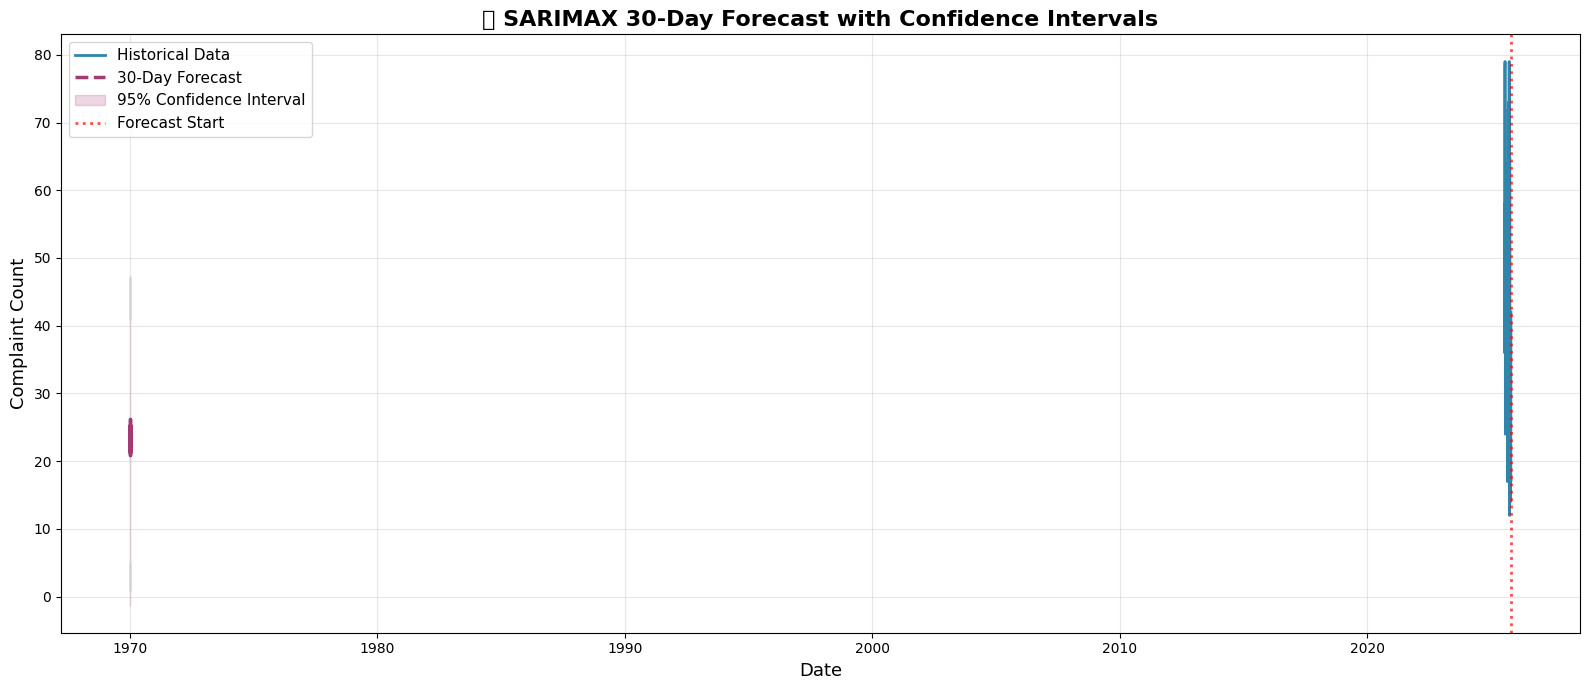

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Get forecast and confidence intervals from your model
n_steps = 30
forecast_obj = results.get_forecast(steps=n_steps, exog=X_future)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Ensure forecast index is datetime
forecast_dates = pd.to_datetime(forecast_mean.index)

# ✅ Build clean DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Complaints': forecast_mean.values,
    'Lower_CI_95%': forecast_ci.iloc[:, 0].values,
    'Upper_CI_95%': forecast_ci.iloc[:, 1].values
})

# ✅ Convert types safely
forecast_df = forecast_df.astype({
    'Forecasted_Complaints': 'float',
    'Lower_CI_95%': 'float',
    'Upper_CI_95%': 'float'
})

# ✅ Plot
plt.figure(figsize=(16, 7))

# Plot recent historical data
historical_window = min(90, len(y))
plt.plot(
    pd.to_datetime(y.index[-historical_window:]),
    y.iloc[-historical_window:].values,
    label='Historical Data',
    color='#2E86AB',
    linewidth=2
)

# Plot forecast
plt.plot(
    forecast_df['Date'],
    forecast_df['Forecasted_Complaints'],
    label='30-Day Forecast',
    color='#A23B72',
    linewidth=2.5,
    linestyle='--'
)

# Plot confidence interval
plt.fill_between(
    forecast_df['Date'],
    forecast_df['Lower_CI_95%'],
    forecast_df['Upper_CI_95%'],
    color='#A23B72',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Mark forecast start
plt.axvline(x=pd.to_datetime(y.index[-1]), color='red', linestyle=':', linewidth=2, alpha=0.7, label='Forecast Start')

# Formatting
plt.title('🔮 SARIMAX 30-Day Forecast with Confidence Intervals', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Complaint Count', fontsize=13)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


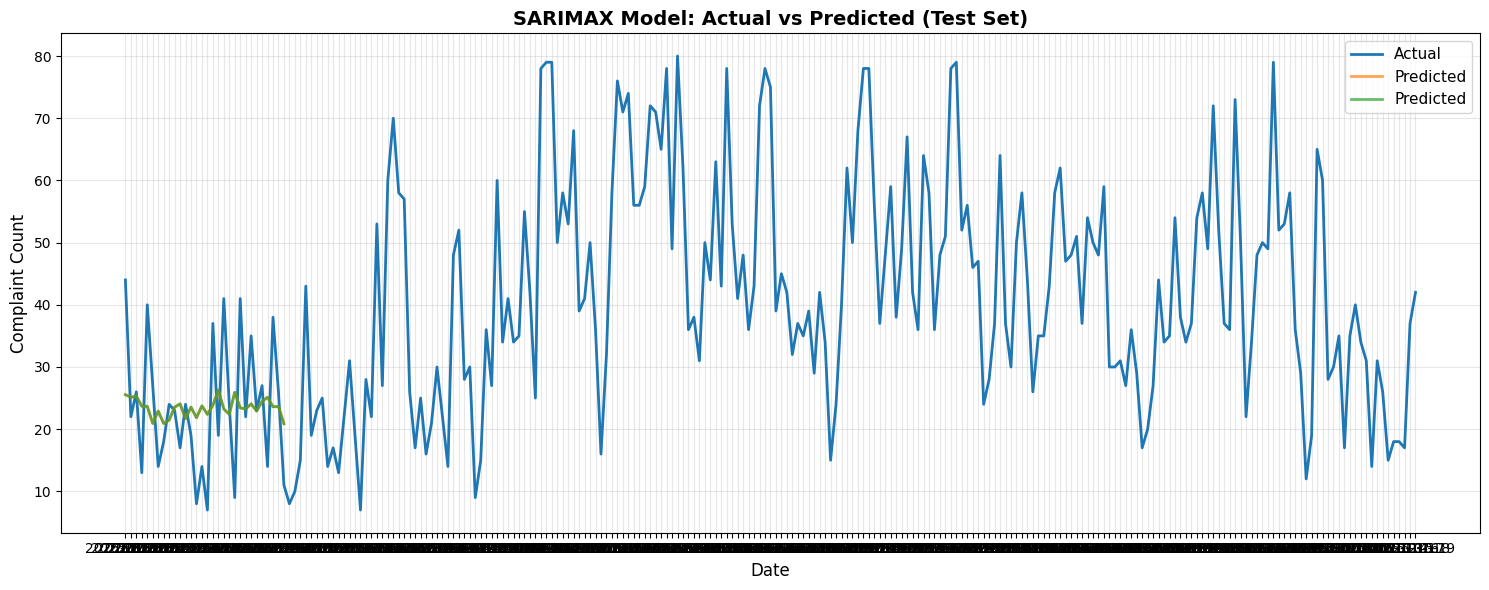

In [70]:
# VISUALIZATION OF TEST SET PREDICTIONS
plt.figure(figsize=(15, 6))
plt.plot(df.index[train_size:], y_test.values, label='Actual', linewidth=2)
plt.plot(forcast.index, forcast['Pred'], forecast_series.values, 
         label='Predicted', linewidth=2, alpha=0.7)
plt.title('SARIMAX Model: Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Complaint Count', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
